In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
# Iako slike kad se pogledaju izgledaju kao da su crno bele nece tako biti ucitane
# pa moramo da pored standardnog pretvaranja u Tensor, pretvorimo i u greyscale da bismo sveli samo na jedan kanal.
loading_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

In [3]:
#load the data
train_dataset       = datasets.ImageFolder(root='../data/Training', transform=loading_transform) 
validation_dataset  = datasets.ImageFolder(root='../data/Validation', transform=loading_transform)
test_dataset        = datasets.ImageFolder(root='../data/Test', transform=loading_transform)

In [4]:
print(f"Training dataset size:      {len(train_dataset)} instances")
print(f"Validation dataset size:    {len(validation_dataset)} instances")
print(f"Test dataset size:          {len(test_dataset)} instances")

Training dataset size:      28709 instances
Validation dataset size:    3589 instances
Test dataset size:          3589 instances


In [5]:
# Make dataloaders
train_dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(dataset=validation_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

In [6]:
img, label = train_dataset[0]

In [7]:
img.shape

torch.Size([1, 48, 48])

In [8]:
import torch.nn.functional as F
from torch import nn
import torch

In [9]:
class FullyConnectedNN(nn.Module):
    def __init__(self):
        super().__init__()
        

        self.dense1 = nn.Linear(2304,128)
        self.dense2 = nn.Linear(128, 64)
        self.dense3 = nn.Linear(64,32)
        self.final = nn.Linear(32,7)
        
        self.flatten = nn.Flatten(start_dim=1)

    def forward(self, x):
        
        x = self.flatten(x)

        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
        x = F.relu(self.dense3(x))
        x = self.final(x)

        return x

In [10]:
class simpleConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        
        self.layer1 = nn.Conv2d(1,32,3) 
                                        
        self.layer2 = nn.Conv2d(32,64,3)
        self.pool = nn.MaxPool2d(2)
        self.flatten = nn.Flatten(start_dim=1)
        self.final_layer = nn.Linear(6400,7)

    def forward(self, x):

        x = F.relu(self.layer1(x))
        x = self.pool(x)

        x = F.relu(self.layer2(x))
        x = self.pool(x)

        x = self.flatten(x)
        return self.final_layer(x)

In [11]:
class EmotionNet(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(in_features=128 * 6 * 6, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=num_classes)

        self.flatten = nn.Flatten(start_dim=1)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))

        x = self.pool(F.relu(self.conv2(x)))

        x = self.pool(F.relu(self.conv3(x)))

        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [12]:
class EDA_CNN(nn.Module):
    def __init__(self):
        super().__init__()

        
        self.layer1 = nn.Conv2d(1,32,3) 
                                        
        self.layer2 = nn.Conv2d(32,64,3)
        self.pool = nn.MaxPool2d(2)
        self.flatten = nn.Flatten(start_dim=1)
        self.dense1 = nn.Linear(6400,64)
        self.dense2 = nn.Linear(64,7)

    def forward(self, x):

        x = F.relu(self.layer1(x))
        x = self.pool(x)

        x = F.relu(self.layer2(x))
        x = self.pool(x)

        x = self.flatten(x)
        
        x = F.relu(self.dense1(x))
        x = F.softmax(self.dense2(x))
        return x

In [13]:
scn = simpleConvNet()

In [14]:
scn(img.reshape(1,1,48,48))

tensor([[ 0.0762, -0.0804,  0.1197, -0.0048, -0.0302,  0.0264,  0.0183]],
       grad_fn=<AddmmBackward0>)

In [15]:
emoNet = EmotionNet()

In [16]:
emoNet(img.reshape(1,1,48,48))

tensor([[ 0.0330, -0.0020,  0.0459,  0.0519, -0.0141, -0.0222, -0.0259]],
       grad_fn=<AddmmBackward0>)

In [17]:
eda_cnn = EDA_CNN()

In [18]:
eda_cnn(img.reshape(1,1,48,48))

/tmp/ipykernel_39861/3233798655.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.dense2(x))


tensor([[0.1501, 0.1440, 0.1458, 0.1297, 0.1498, 0.1383, 0.1423]],
       grad_fn=<SoftmaxBackward0>)

In [19]:
fcnn = FullyConnectedNN()

In [20]:
fcnn(img.reshape(1,1,48,48))

tensor([[ 0.0445, -0.0114,  0.1057, -0.1700,  0.0469, -0.0791,  0.1365]],
       grad_fn=<AddmmBackward0>)

In [21]:
label

0

In [22]:
from torch import optim

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
loss_fn = nn.CrossEntropyLoss()

In [24]:
test_img, test_label = test_dataset[2000]

In [25]:
print(test_img.shape)
print(test_label)

torch.Size([1, 48, 48])
4


In [26]:
scn(test_img.reshape(1,1,48,48))

tensor([[ 0.0706, -0.1058,  0.0989, -0.0178, -0.0298,  0.0223,  0.0083]],
       grad_fn=<AddmmBackward0>)

In [27]:
emoNet(test_img.reshape(1,1,48,48))

tensor([[ 0.0232, -0.0171,  0.0580, -0.0409, -0.0398, -0.0174, -0.0216]],
       grad_fn=<AddmmBackward0>)

In [28]:
eda_cnn(test_img.reshape(1,1,48,48))

/tmp/ipykernel_39861/3233798655.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.dense2(x))


tensor([[0.1504, 0.1438, 0.1460, 0.1296, 0.1500, 0.1369, 0.1432]],
       grad_fn=<SoftmaxBackward0>)

In [29]:
import numpy as np

In [30]:
import function_lib as flib

In [31]:
losses = []
accs = []

optimizer = optim.Adam(params=emoNet.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10,gamma=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, step_size_up=2000, mode='triangular')

(losses, accs) = flib.train(emoNet, train_dataloader, validation_dataloader, loss_fn,optimizer, losses=losses, accs=accs,num_epochs=10)
flib.save_model(model=emoNet, model_name="emoNet",path="../models")

Training epoch: 1...
Total loss: 172.24362111091614
Accuracy: 0.41014210086375036
Training epoch: 2...
Total loss: 157.8295851945877
Accuracy: 0.4575090554471998
Training epoch: 3...
Total loss: 150.235227227211
Accuracy: 0.4831429367511842
Training epoch: 4...
Total loss: 144.64310282468796
Accuracy: 0.502089718584564
Training epoch: 5...
Total loss: 141.10841244459152
Accuracy: 0.5182502089718585
Training epoch: 6...
Total loss: 139.3230301141739
Accuracy: 0.5249373084424631
Training epoch: 7...
Total loss: 139.68401992321014
Accuracy: 0.523822791864029
Training epoch: 8...
Total loss: 134.6783720254898
Accuracy: 0.539704653106715
Training epoch: 9...
Total loss: 134.39041298627853
Accuracy: 0.5463917525773195
Training epoch: 10...
Total loss: 139.22453010082245
Accuracy: 0.5511284480356645
models directory already exists
Saving model...
Model 'emoNet' saved successfully.


In [32]:
flib.print_trainable_params(emoNet)

Total number of trainable parameters: 2456071


In [33]:
losses

[172.24362111091614,
 157.8295851945877,
 150.235227227211,
 144.64310282468796,
 141.10841244459152,
 139.3230301141739,
 139.68401992321014,
 134.6783720254898,
 134.39041298627853,
 139.22453010082245]

In [34]:
pred = emoNet(test_img.reshape(1,1,48,48))
result = pred.detach().cpu().numpy()[0]
print(result)
print(np.argmax(result))

[ 0.16833192 -2.89364    -0.3584064  -1.0334903   0.34604153  0.6674953
 -2.6766405 ]
5


In [35]:
test_label

4

In [36]:
from matplotlib import pyplot as plt

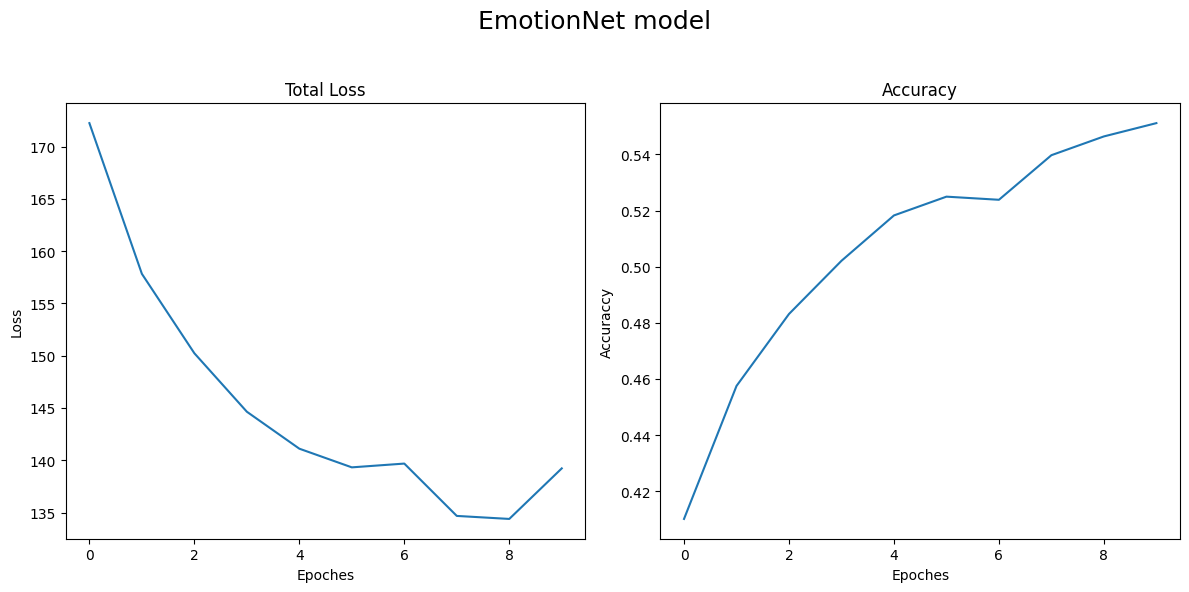

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot Loss
ax1.plot(range(len(losses)), losses)
ax1.set_title("Total Loss")
ax1.set_xlabel("Epoches")
ax1.set_ylabel("Loss")

# Plot Accuracy
ax2.plot(range(len(losses)), accs)
ax2.set_title("Accuracy")
ax2.set_xlabel("Epoches")
ax2.set_ylabel("Accuraccy")

plt.suptitle("EmotionNet model", fontsize=18)

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

In [38]:
losses = []
accs = []

optimizer = optim.Adam(params=scn.parameters(), lr=0.001)

(losses, accs) = flib.train(scn, train_dataloader=train_dataloader, validation_dataloader=validation_dataloader, loss_fn=loss_fn, optimizer=optimizer, losses=losses, accs=accs,num_epochs=10)
flib.save_model(model=scn, model_name="simpleConvNN",path="../models")

Training epoch: 1...
Total loss: 166.65481662750244
Accuracy: 0.43354694901086654
Training epoch: 2...
Total loss: 157.81692349910736
Accuracy: 0.4566731680133742
Training epoch: 3...
Total loss: 152.19933354854584
Accuracy: 0.4797993870158819
Training epoch: 4...
Total loss: 148.32393598556519
Accuracy: 0.4948453608247423
Training epoch: 5...
Total loss: 148.03550165891647
Accuracy: 0.5129562552242964
Training epoch: 6...
Total loss: 149.36358952522278
Accuracy: 0.5029256060183895
Training epoch: 7...
Total loss: 145.79551243782043
Accuracy: 0.5093340763443857
Training epoch: 8...
Total loss: 144.63767856359482
Accuracy: 0.5188074672610755
Training epoch: 9...
Total loss: 143.66845738887787
Accuracy: 0.5260518250208972
Training epoch: 10...
Total loss: 145.12897664308548
Accuracy: 0.518528838116467
models directory already exists
Saving model...
Model 'simpleConvNN' saved successfully.


In [39]:
flib.print_trainable_params(scn)

Total number of trainable parameters: 63623


In [40]:
pred = scn(test_img.reshape(1,1,48,48))
result = pred.detach().cpu().numpy()[0]
print(result)
print(np.argmax(result))

[-0.29164952 -3.0852838  -0.6081276  -2.0847478  -0.20049742  1.1647369
 -4.1925645 ]
5


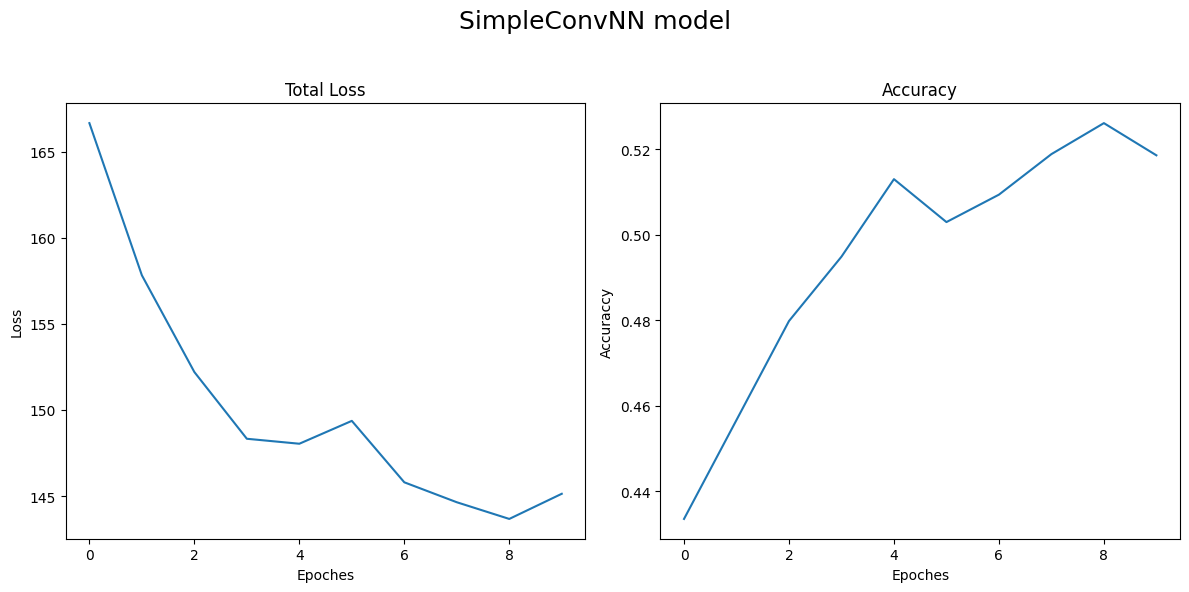

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot Loss
ax1.plot(range(len(losses)), losses)
ax1.set_title("Total Loss")
ax1.set_xlabel("Epoches")
ax1.set_ylabel("Loss")

# Plot Accuracy
ax2.plot(range(len(losses)), accs)
ax2.set_title("Accuracy")
ax2.set_xlabel("Epoches")
ax2.set_ylabel("Accuraccy")

plt.suptitle("SimpleConvNN model", fontsize=18)

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

In [42]:
losses = []
accs = []

optimizer = optim.Adam(params=eda_cnn.parameters(), lr=0.001)

(losses, accs) = flib.train(eda_cnn, train_dataloader=train_dataloader, validation_dataloader=validation_dataloader, loss_fn=loss_fn, optimizer=optimizer, losses=losses, accs=accs,num_epochs=10)
flib.save_model(model=eda_cnn, model_name="EDA_CNN",path="../models")

Training epoch: 1...


/tmp/ipykernel_39861/3233798655.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.dense2(x))


Total loss: 205.1426694393158
Accuracy: 0.3471719141822235
Training epoch: 2...
Total loss: 202.27469968795776
Accuracy: 0.3677904708832544
Training epoch: 3...
Total loss: 200.64971089363098
Accuracy: 0.38227918640289776
Training epoch: 4...
Total loss: 197.70747900009155
Accuracy: 0.4045695179715798
Training epoch: 5...
Total loss: 197.15452790260315
Accuracy: 0.41125661744218445
Training epoch: 6...
Total loss: 196.22252714633942
Accuracy: 0.4165505711897464
Training epoch: 7...
Total loss: 194.4582952260971
Accuracy: 0.43800501532460295
Training epoch: 8...
Total loss: 193.55785644054413
Accuracy: 0.43939816104764556
Training epoch: 9...
Total loss: 194.19205260276794
Accuracy: 0.44106993591529675
Training epoch: 10...
Total loss: 193.10102105140686
Accuracy: 0.44664251880746725
models directory already exists
Saving model...
Model 'EDA_CNN' saved successfully.


In [43]:
flib.print_trainable_params(eda_cnn)

Total number of trainable parameters: 428935


In [44]:
pred = eda_cnn(test_img.reshape(1,1,48,48))
result = pred.detach().cpu().numpy()[0]
print(result)
print(np.argmax(result))

[6.69976473e-01 6.35538150e-12 1.91660435e-03 1.14933864e-04
 3.00855517e-01 2.71364599e-02 3.86782837e-12]
0


/tmp/ipykernel_39861/3233798655.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.dense2(x))


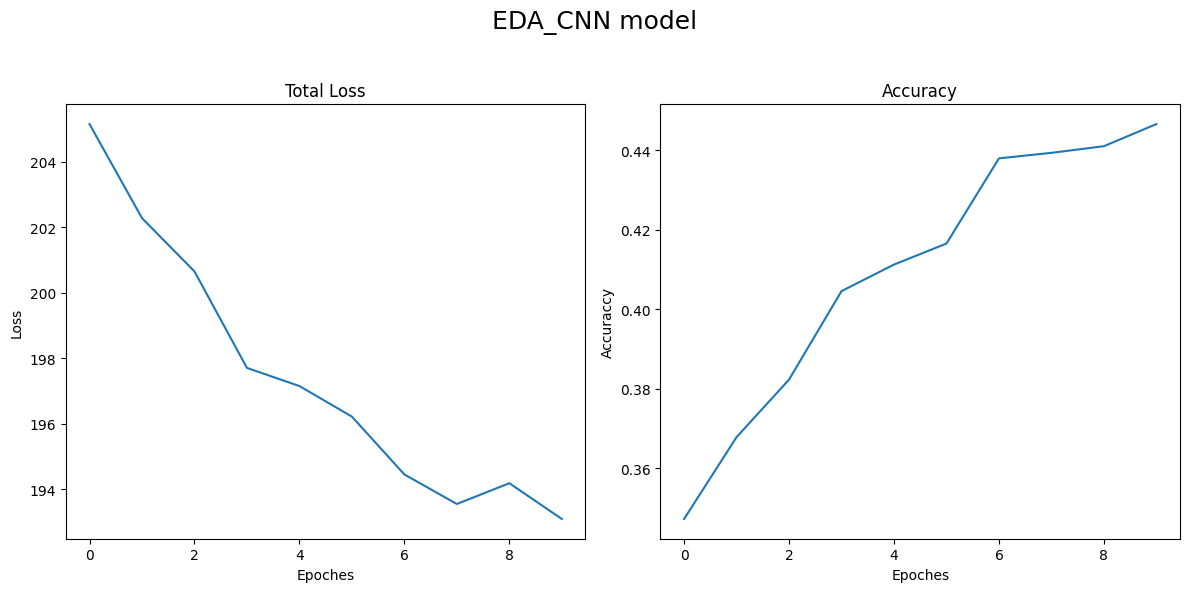

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot Loss
ax1.plot(range(len(losses)), losses)
ax1.set_title("Total Loss")
ax1.set_xlabel("Epoches")
ax1.set_ylabel("Loss")

# Plot Accuracy
ax2.plot(range(len(losses)), accs)
ax2.set_title("Accuracy")
ax2.set_xlabel("Epoches")
ax2.set_ylabel("Accuraccy")

plt.suptitle("EDA_CNN model", fontsize=18)

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

In [46]:
losses = []
accs = []

optimizer = optim.Adam(params=fcnn.parameters(), lr=0.001)

(losses, accs) = flib.train(fcnn, train_dataloader=train_dataloader, validation_dataloader=validation_dataloader, loss_fn=loss_fn, optimizer=optimizer, losses=losses, accs=accs,num_epochs=10)
flib.save_model(model=fcnn, model_name="fullyConnectedNN",path="../models")

Training epoch: 1...
Total loss: 192.8188375234604
Accuracy: 0.30788520479242126
Training epoch: 2...
Total loss: 187.5046433210373
Accuracy: 0.3499582056283087
Training epoch: 3...
Total loss: 186.35391747951508
Accuracy: 0.35803845082195596
Training epoch: 4...
Total loss: 183.6011198759079
Accuracy: 0.36277514628030094
Training epoch: 5...
Total loss: 182.64474427700043
Accuracy: 0.3719699080523823
Training epoch: 6...
Total loss: 184.31645572185516
Accuracy: 0.36221788799108384
Training epoch: 7...
Total loss: 180.13262498378754
Accuracy: 0.3808860406798551
Training epoch: 8...
Total loss: 180.79382026195526
Accuracy: 0.3725271663415993
Training epoch: 9...
Total loss: 182.28043675422668
Accuracy: 0.3644469211479521
Training epoch: 10...
Total loss: 177.09951519966125
Accuracy: 0.38785176929506826
models directory already exists
Saving model...
Model 'fullyConnectedNN' saved successfully.


In [47]:
flib.print_trainable_params(fcnn)

Total number of trainable parameters: 305607


In [48]:
pred = fcnn(test_img.reshape(1,1,48,48))
result = pred.detach().cpu().numpy()[0]
print(result)
print(np.argmax(result))

[ 0.36565185 -2.1271765  -0.40686387  0.7212339   0.2881378   0.13791707
 -1.9016813 ]
3


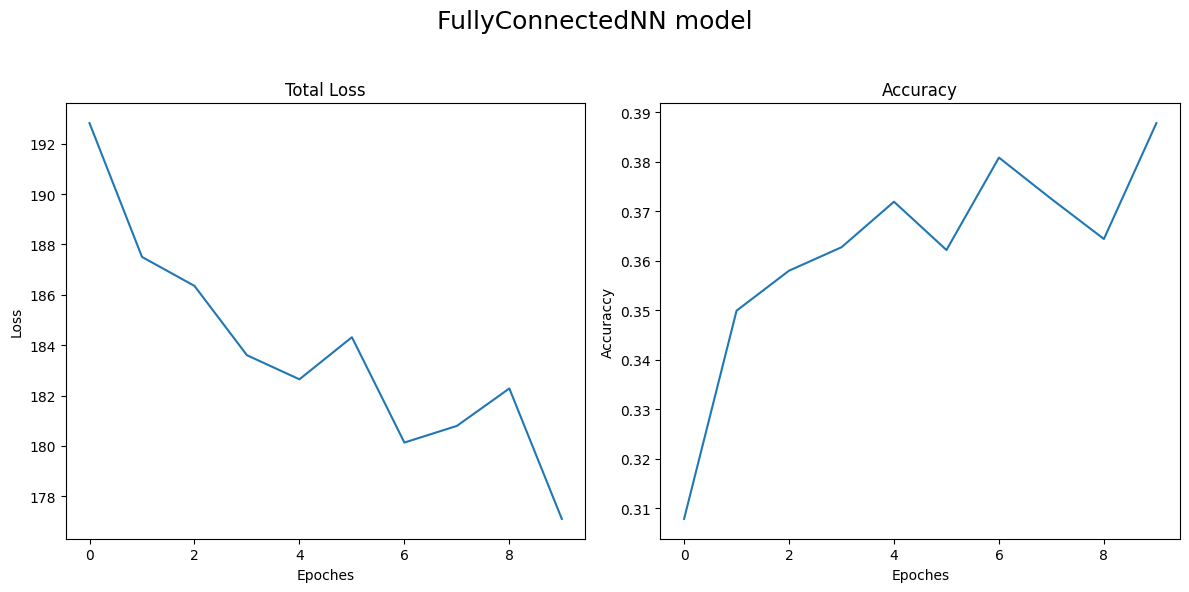

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot Loss
ax1.plot(range(len(losses)), losses)
ax1.set_title("Total Loss")
ax1.set_xlabel("Epoches")
ax1.set_ylabel("Loss")

# Plot Accuracy
ax2.plot(range(len(losses)), accs)
ax2.set_title("Accuracy")
ax2.set_xlabel("Epoches")
ax2.set_ylabel("Accuraccy")

plt.suptitle("FullyConnectedNN model", fontsize=18)

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()